Using MPS


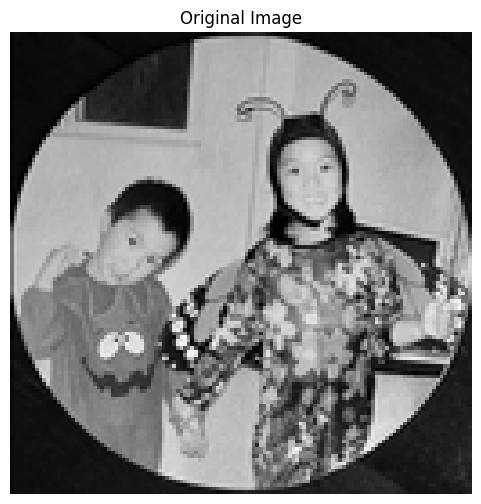

TypeError: tensor() takes 1 positional argument but 2 were given

In [7]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")

elif torch.backends.mps.is_available():
    if torch.backends.mps.is_built():
        device = torch.device("mps")
        print("Using MPS")
    else:
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Load and normalize the image
image_path = './jyjy.jpeg'
image = Image.open(image_path).convert('L')

desired_size = (128, 128)  # Desired resolution
image = image.resize(desired_size, Image.LANCZOS)

img_np = np.array(image) / 255.0
img_tensor = torch.tensor(img_np).float().to(device)

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(img_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

# Define the 2D Gaussian function with a color intensity parameter and rotation angle
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, color_intensity, rotation_angle):
    # Calculate the centered coordinates
    x_centered = x - mu_x
    y_centered = y - mu_y
    
    # Rotate the coordinates
    x_rot = x_centered * torch.cos(rotation_angle) - y_centered * torch.sin(rotation_angle)
    y_rot = x_centered * torch.sin(rotation_angle) + y_centered * torch.cos(rotation_angle)
    
    exponent = -((x_rot**2) / (2*sigma_x**2) + (y_rot**2) / (2*sigma_y**2))
    return (torch.exp(exponent)) * color_intensity

# Model the image using a set of rotated Gaussians
def model_image(params, shape):
    x = torch.linspace(0, shape[1] - 1, shape[1]).to(device)
    y = torch.linspace(0, shape[0] - 1, shape[0]).to(device)
    x, y = torch.meshgrid(x, y)
    model = torch.zeros_like(x)
    
    for i in range(0, len(params), 7): 
        mu_x, mu_y, sigma_x, sigma_y, color_intensity, rotation_angle, _ = params[i:i+7]
        model += gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, color_intensity, rotation_angle)
    
    return model

# Mean squared error loss function
def mse_loss(params):
    model = model_image(params, img_tensor.shape)
    loss = torch.mean((model - img_tensor)**2)
    return loss

# Initialization using grid approach and sampling the image
num_gaussians = 2000
grid_size = int(np.sqrt(num_gaussians))
params = []
image_height, image_width = img_tensor.shape

for i in range(grid_size):
    for j in range(grid_size):
        # Calculate the coordinates within the image
        x_coord = (i * image_width) // grid_size
        y_coord = (j * image_height) // grid_size
        
        # Sample the color intensity from the image at the calculated coordinates
        color_intensity = img_tensor[y_coord, x_coord]
        # print(color_intensity)
        
        mu_x = torch.tensor(x_coord).float().to(device)
        mu_y = torch.tensor(y_coord).float().to(device)
        sigma_x = torch.randn(1).mul(2).add(1).clamp(1, 20).to(device)
        sigma_y = torch.randn(1).mul(2).add(1).clamp(1, 20).to(device)
        rotation_angle = torch.rand(1).mul(2 * np.pi).to(device)  # Random rotation angle
        
        params.extend([mu_x.item(), mu_y.item(), sigma_x.item(), sigma_y.item(), color_intensity.item(), rotation_angle.item(), 0.0])

params = torch.tensor(params, device=device).requires_grad_()
optimizer = optim.Adam([params], lr=0.4)  # Slightly increase learning rate to observe effects
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)

# Display the initial Gaussian-based reconstruction
initial_model = model_image(params, img_tensor.shape).cpu().detach().numpy()
plt.figure(figsize=(6, 6))
plt.imshow(initial_model, cmap='gray')
plt.title("Initial Gaussian Reconstruction")
plt.axis('off')
plt.show()

# Optimize with scheduler step
iterations = 100
display_interval = 10  # Display the Gaussian centers every 100 iterations

for iteration in range(iterations):
    optimizer.zero_grad()
    loss = mse_loss(params)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if iteration % display_interval == 0:
        # Display Gaussian centers intermittently
        plt.figure(figsize=(6, 6))
        plt.imshow(img_np, cmap='gray')
        plt.scatter(params[::7].cpu().detach().numpy(), params[1::7].cpu().detach().numpy(), color='red', s=1)
        plt.title(f"Gaussian Centers at Iteration {iteration}")
        plt.axis('off')
        plt.show()

        model = model_image(params, img_tensor.shape).cpu().detach().numpy()
        plt.figure(figsize=(6, 6))
        plt.imshow(model, cmap='gray')
        plt.title("Gaussian Reconstruction")
        plt.axis('off')
        plt.show()
    
    print(f"Iteration {iteration + 1}/{iterations}, Loss: {loss.item()}, LR: {scheduler.get_last_lr()[0]}")

# Display result
result = model_image(params, img_tensor.shape).cpu().detach().numpy()
plt.figure(figsize=(6, 6))
plt.imshow(result, cmap='gray')
plt.title("Final Gaussian Reconstruction")
plt.axis('off')
plt.show()